# Driver of LIM using PyTorch

## Import Modules

In [1]:
# import modules
import math
import numpy as np
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

from lim_mod_pt import LIM

import torch
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

## Data

In [2]:
# data
if False:
    # red noise
    from ode_AM_index_config import get_red_noise as get_data
    gamma = [0.06]
    true_t, true_y = get_data(gamma=gamma, data_size=10000)
else:
    # annular mode
    from read_AM_index_mod import get_AM_index as get_data
    t_np, y_np, p_np = get_data()

t = torch.from_numpy(t_np)
if y_np.ndim == 1:
    y = torch.from_numpy(y_np)[:,None]
else:
    y = torch.from_numpy(y_np)

print(f't.shape = {t.shape}, y.shape = {y.shape}')

# test of the method for eigen decomposition
# from lim_mod_pt import cal_Gt, test_eig_m
# Gt = cal_Gt(y, 5, verbose=True)
# test_eig_m(y, 5)

Reading from saved data ......
Use pressure levels = [   1.    2.    3.    5.    7.   10.   20.   30.   50.   70.  100.  125.
  150.  175.  200.  225.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  775.  800.  825.  850.  875.  900.  925.  950.  975.
 1000.]

t.shape = torch.Size([21535]), y.shape = torch.Size([21535, 37])


## Model

rank of inverted matrix =14
rank of inverted matrix =37
diagonal(vrH_vr)=
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
norm(vlH - vlH @ vr @vlH) = 0.001919466070830822
norm(vr - vr @ vlH @vr) = 2.165480691473931e-05
norm(a - vr @ diag(w) @vlH) = 0.0010529335122555494
POP e-folding timescales =
 tensor([23.2713, 23.2713, 19.8745, 19.8745, 12.3628,  9.5642,  9.5642,  7.6219,
         7.6219,  6.8329,  5.3913,  5.3913,  4.1617,  4.1617,  0.5198,  0.5169,
         0.5169,  0.4775,  0.4775,  0.4399,  0.5101,  0.5101,  0.4711,  0.4711,
         0.3749,  0.4913,  0.4913,  0.4440,  0.4440,  0.4291,  0.4805,  0.4805,
         0.5019,  0.5019,  0.4968,  0.5169,  0.5169])

y(t, x) = torch.Size([21535, 37])
yf(

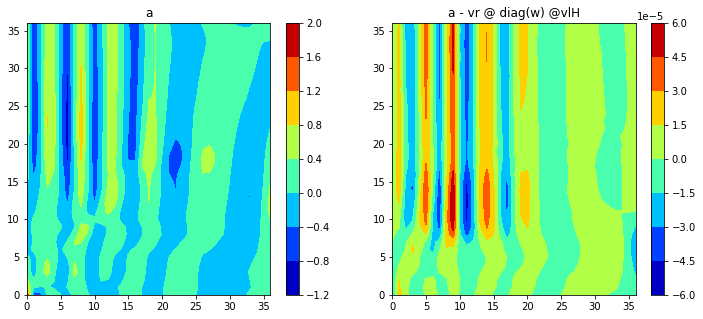

In [3]:
lag = 5
model = LIM(y, lag=lag, eig_method='pinv', verbose=True)

lag_time = 90
yf = model.forecast(y[:-lag_time], t[:lag_time+1])
yf_np = yf.numpy()
print(f"\ny(t, x) = {y.shape}")
print(f"yf(lag, batch, x) = {yf.shape}")

## Plot the linear operator 

Ct = torch.Size([37, 37])
Ctf = torch.Size([37, 37])


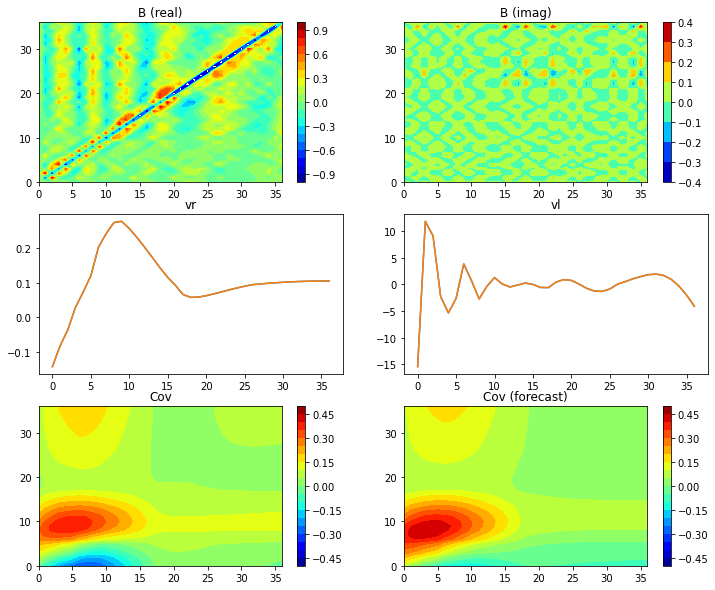

In [4]:
val_time = 30
Ct = y[val_time:].T @ y[:-val_time] / (len(y)-val_time)
Ctf = yf[val_time,:,:].T @ yf[0,:,:] / yf.shape[1]
print(f"Ct = {Ct.shape}")
print(f"Ctf = {Ctf.shape}")

fig = plt.figure(figsize=(12,10))
cmax = 1
ax = fig.add_subplot(3,2,1)
plt.contourf(model.B.real.numpy(), np.linspace(-cmax, cmax, 21))
plt.title('B (real)')
plt.colorbar()

ax = fig.add_subplot(3,2,2)
plt.contourf(model.B.imag.numpy())
plt.title('B (imag)')
plt.colorbar()

ax = fig.add_subplot(3,2,3)
plt.plot(model.vr.real[:,:2].numpy())
plt.title('vr')

ax = fig.add_subplot(3,2,4)
plt.plot(model.vl.real[:,:2].numpy())
plt.title('vl')

cmax = 0.5
ax = fig.add_subplot(3,2,5)
plt.contourf(Ct.numpy(), np.linspace(-cmax, cmax, 21))
plt.title('Cov')
plt.colorbar()

ax = fig.add_subplot(3,2,6)
plt.contourf(Ctf.numpy(), np.linspace(-cmax, cmax, 21))
plt.title('Cov (forecast)')
plt.colorbar()

## Plot autocovariance

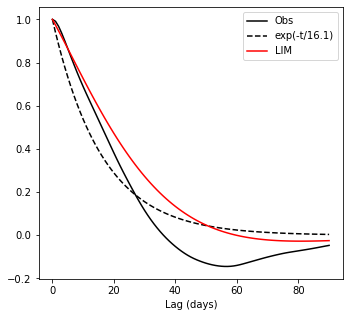

In [5]:
from plot_AM_index_mod import plot_cov

k = np.isin(p_np, 10).nonzero()[0][0]
plot_cov(y_np, yf=yf_np, k=k, lag_time=lag_time)


## Plot lagged covariance

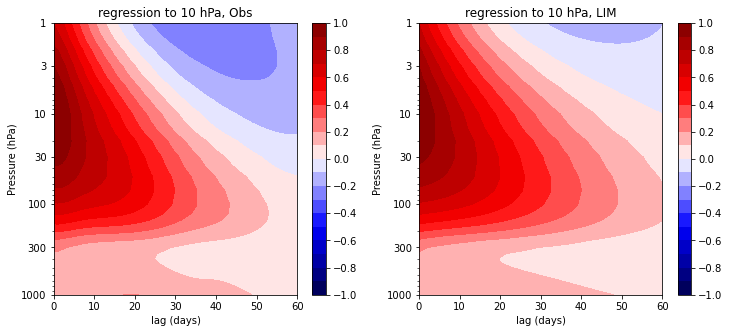

In [6]:
from plot_AM_index_mod import plot_lag_reg

plot_lag_reg(y_np, p_np, yf_np)

## Make composite for strong and weak vortex events


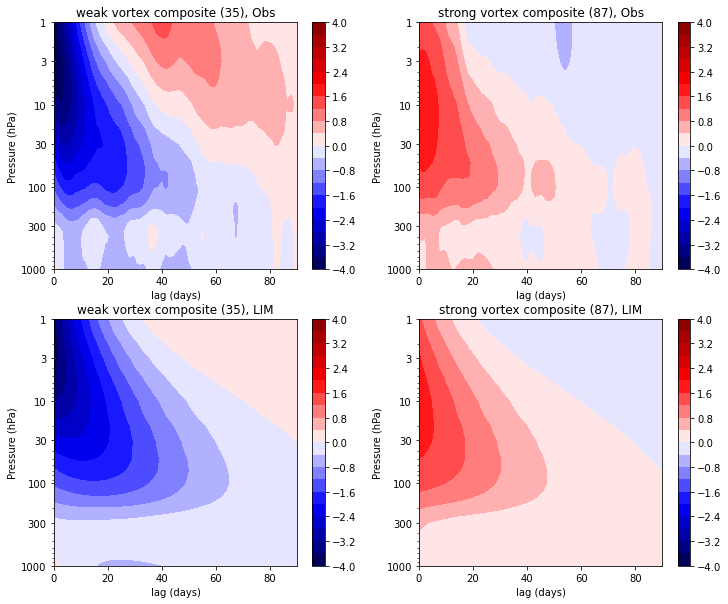

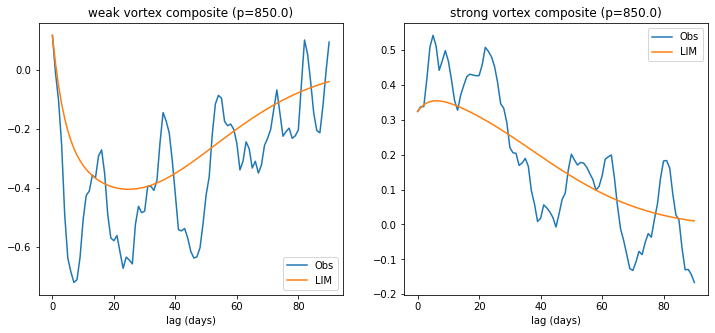

In [7]:
from plot_AM_index_mod import plot_event

plot_event(y_np, p_np, yf=yf_np, lag_time=lag_time)